In [ ]:
import JSSP
import time
import numpy as np
import random
import gym
import itertools
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.style
import pandas as pd
import sys


from collections import defaultdict
#import plotting

# Environment Initialization

In [ ]:
def create_env(instance_path):
    env_name = "JSSP-v0"
    env = gym.make(env_name, instance_path = instance_path)
    print("Environment Created for: ", instance_path)
    print("Observation space: \n", env.observation_space)
    print("Action space: \n", env.action_space)
    return env

In [ ]:
env1 = create_env("instance1.txt")
env3 = create_env("instance3.txt")
env4 = create_env("instance4.txt")

# Baselines

## 1. Random Sampling

In [88]:
def random_sampling(env, episodes):
    env.reset()
    max_score = -100000
    max_episode = -1
    max_action_list = []
    max_time_list = []
    for episode in range(1, episodes+1):
        env.reset()
        done = False
        score = 0
        action_list = []
        time_list = []
        while not done:
            #env.render()
            action = env.action_space.sample()
            if action != env.action_space.n -1:
                action_list.append(env.legal_allocation_list[action])
                time_list.append(env.time)
                # print('Episode:{} Allocation:{} Time:{}'.format(episode, env.legal_allocation_list[action], env.time))
            n_state, reward, done, info = env.step(action)
            score+=reward
        # print('Episode:{} Total_reward:{}'.format(episode, score))
        if score >= max_score:
            max_score = score
            max_episode = episode
            max_action_list = action_list
            max_time_list = time_list
    print('From {}th Episode best policy has reward {}'.format(max_episode, max_score))
    for i in range(len(max_action_list)):
        print('The allocation chose at time {} is {}'.format(max_time_list[i], max_action_list[i]))

## 2. Q-Learning

In [89]:
# def createEpsilonGreedyPolicy(Q, epsilon, num_actions):
# 	"""
# 	Creates an epsilon-greedy policy based
# 	on a given Q-function and epsilon.
#
# 	Returns a function that takes the state
# 	as an input and returns the probabilities
# 	for each action in the form of a numpy array
# 	of length of the action space(set of possible actions).
# 	"""
def policy(state, Q, epsilon, num_actions):

    if state in Q:
        best_action = np.argmax(Q[state])
        Action_probabilities = np.ones(num_actions, dtype = float) * epsilon / num_actions
        Action_probabilities[best_action] += (1.0 - epsilon)
        return Action_probabilities

    Action_probabilities = np.ones(num_actions, dtype = float) / num_actions
    return Action_probabilities

In [90]:
def update(Q, state, next_state, action, reward, eta, gamma):

    if next_state not in Q:
        Q_next_state_max = -1
    else:
        Q_next_state_max = max(Q[next_state])

    Q[state][action] = Q[state][action] + eta * (reward + gamma * Q_next_state_max - Q[state][action])

    return Q

In [91]:
def q_learning(env, epis):

    max_score = -100000
    max_episode = -1
    max_action_list = []
    max_time_list = []

    # 1. Load Environment and Q-table structure
    Q_table = {}
    # 2. Parameters of Q-learning
    eta = .628
    gamma = 1
    epsilon = .1
    decay_rate = .0001
    total_reward_list = [] # rewards per episode calculate
    testing_reward_list = []
    # 3. Q-learning Algorithm
    for episode in range(epis):
        # Reset environment
        state = env.reset()
        total_reward = 0
        done = False
        action_list = []
        time_list = []

        # The Q-Table learning algorithm
        while not done:
            if epsilon >= decay_rate:
                epsilon -= decay_rate
            if state not in Q_table:
                Q_table[state] = np.zeros(env.action_space.n)
            action_probabilities = policy(state, Q_table, epsilon, env.action_space.n)
            action = np.random.choice(np.arange(len(action_probabilities)), p = action_probabilities)
            if action != env.action_space.n -1:
                action_list.append(env.legal_allocation_list[action])
                time_list.append(env.time)
                #print('Episode:{} Allocation:{} Time:{}'.format(episode, env.legal_allocation_list[action], env.time))
            #Get new state & reward from environment
            next_state, reward, done, _ = env.step(action)
            #Update Q-Table with new knowledge
            Q_table = update(Q_table, state, next_state, action, reward, eta, gamma)
            if eta > .01:
                eta -= decay_rate
            total_reward += reward
            state = next_state
        total_reward_list.append(total_reward)
        # keep policy testing results every 100 episodes
        if episode % 100 == 0:
            testing_reward_list.append(total_reward)
        if total_reward >= max_score:
            max_score = total_reward
            max_episode = episode
            max_action_list = action_list
            max_time_list = time_list
        print("Episode: " + str(episode) + " has time " + str(env.time))

    print('From {}th Episode best policy has reward {}'.format(max_episode + 1, max_score))
    for i in range(len(max_action_list)):
        print('The allocation chose at time {} is {}'.format(max_time_list[i], max_action_list[i]))

    return total_reward_list, Q_table, testing_reward_list

# Analysis

## Random Sampling

In [92]:
random_sampling(env1, 100)

From 3th Episode best policy has reward -53
The allocation chose at time 0 is [-1  0]
The allocation chose at time 2 is [ 1 -1]
The allocation chose at time 17 is [ 2 -1]
The allocation chose at time 20 is [-1  1]
The allocation chose at time 38 is [-1  1]


## QLearning

In [93]:
training_reward_list, Q_table, testing_reward_list = q_learning(env1, 8000)

Episode: 0 has time 65
Episode: 1 has time 76
Episode: 2 has time 84
Episode: 3 has time 69
Episode: 4 has time 67
Episode: 5 has time 67
Episode: 6 has time 64
Episode: 7 has time 104
Episode: 8 has time 82
Episode: 9 has time 58
Episode: 10 has time 60
Episode: 11 has time 63
Episode: 12 has time 66
Episode: 13 has time 71
Episode: 14 has time 78
Episode: 15 has time 73
Episode: 16 has time 65
Episode: 17 has time 58
Episode: 18 has time 60
Episode: 19 has time 66
Episode: 20 has time 67
Episode: 21 has time 55
Episode: 22 has time 63
Episode: 23 has time 66
Episode: 24 has time 60
Episode: 25 has time 64
Episode: 26 has time 59
Episode: 27 has time 84
Episode: 28 has time 68
Episode: 29 has time 83
Episode: 30 has time 81
Episode: 31 has time 69
Episode: 32 has time 80
Episode: 33 has time 67
Episode: 34 has time 74
Episode: 35 has time 76
Episode: 36 has time 84
Episode: 37 has time 77
Episode: 38 has time 89
Episode: 39 has time 136
Episode: 40 has time 73
Episode: 41 has time 62


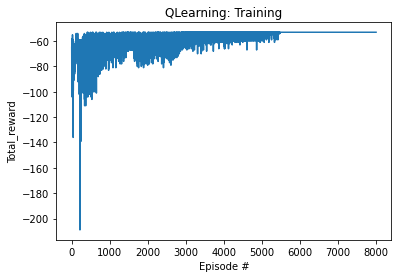

In [94]:
plt.plot(training_reward_list)
plt.title("QLearning: Training")
plt.xlabel("Episode #")
plt.ylabel("Total_reward")
plt.show()


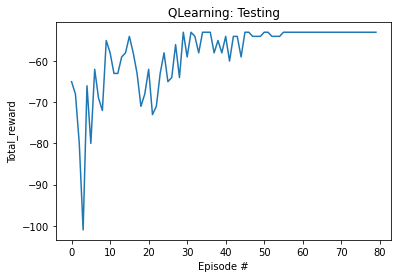

In [95]:
plt.plot(testing_reward_list)
plt.title("QLearning: Testing")
plt.xlabel("Episode #")
plt.ylabel("Total_reward")
plt.show()

In [ ]:
print(Q_table)

## DQN

In [ ]:
from stable_baselines3 import DQN

model = DQN("MlpPolicy", env1, verbose=1)
model.learn(total_timesteps=10000, log_interval=4)
model.save("dqn_FJSSP")

del model # remove to demonstrate saving and loading

model = DQN.load("dqn_FJSSP")

obs = env1.reset()
for episode in range(500):
    env1.reset()
    total_reward = 0
    while not done:
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, info = env1.step(action)
        total_reward += reward
    print("Episode: " + str(episode) + " has reward " + str(total_reward))
        # env.render()